Transfert de style neuronal : 
================================= 
le transfert de style neuronal est une technique d'optimisation utilisée pour prendre deux images - une image de contenu et une image de réference  de style - et les melanger a fin que l'image de sortie  ressemble a l'image de contenu dans le style de l'image de reference 

par exemple 
===================


In [ ]:
import os 
import tensorflow as tf 
import IPython.display as display
import matplotlib.pyplot as plt 
import matplotlib as mp 
mp.rcParams['figure.figsize']=(40,40)
mp.rcParams['axes.grid']=False

import numpy as np 
from PIL import Image
import PIL.Image
import time 
import functools 

In [ ]:
def tensor_to_image(tensor): 
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0]==1
      tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
content=tf.keras.utils.get_file('/content/portrait.jpg','/content/portrait.jpg')
style=tf.keras.utils.get_file('/content/sketching.jpg','/content/sketching.jpg')

VISUALIZATION DES IMAGES 
=============================

In [ ]:
def imshow(image,title=None):
  if len(image.shape) >3 :
    image=tf.squeeze(image,axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
content_image=load_img(content)
style_image=load_img(style)
imshow(content_image,'contenu')

In [ ]:
imshow(style_image,'style')

In [ ]:
x=tf.keras.applications.vgg19.preprocess_input(content_image*255)
x=tf.image.resize(x, (224,224))
vgg=tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg(x)
prediction_probabilities.shape

In [ ]:
predicted_top_5=tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name,prob) for (number,class_name,prob) in predicted_top_5]

In [ ]:
vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
print()
for layer in vgg.layers :
   print(layer.name)

In [ ]:
content_layers=['block5_conv1']
style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1'  ]
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  vgg.trainable=False

  outputs=[vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

pour calculer le style 
======================

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Extraire le style et le contenu
=================================

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Execution une descente en pente
================================= 

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

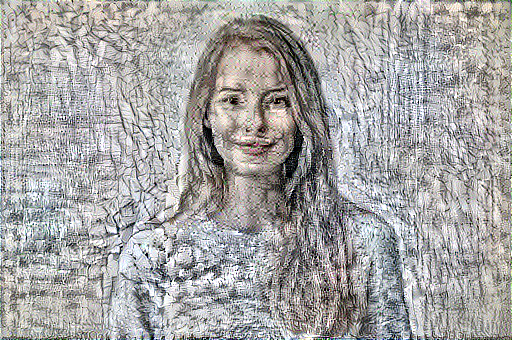

Train step: 700
..........................................................................

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))